In [1]:
import openmc
import urllib
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
import os

In [2]:
url = 'https://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/H/1'
filename, headers = urllib.request.urlretrieve(url,'h1.endf')
url = 'https://t2.lanl.gov/nis/data/data/ENDFB-VII.1-neutron/Zr/90'
filename, headers = urllib.request.urlretrieve(url,'zr90.endf')

# ENDF Data

In [3]:
h_in_zrh  = openmc.data.ThermalScattering.from_njoy('h1.endf'  ,
            'endf_ZrH/HinZrH/tape20' ,temperatures=[293.6], 
            stdout=False, njoy_exec='/Users/ameliajo/NJOY2016/bin/njoy')
zr_in_zrh = openmc.data.ThermalScattering.from_njoy('zr90.endf',
            'endf_ZrH/ZrinZrH/tape20',temperatures=[293.6], 
            stdout=False, njoy_exec='/Users/ameliajo/NJOY2016/bin/njoy')

if os.path.exists("c_H_in_ZrH.h5"):
    os.remove( "c_H_in_ZrH.h5")
    os.remove("c_Zr_in_ZrH.h5")
h_in_zrh.export_to_hdf5('c_H_in_ZrH.h5')
zr_in_zrh.export_to_hdf5('c_Zr_in_ZrH.h5')

!{'cp c_H_in_ZrH.h5 /Users/ameliajo/endfb71_hdf5/'}
!{'cp c_Zr_in_ZrH.h5 /Users/ameliajo/endfb71_hdf5/'}



In [4]:
# Materials 

uo2 = openmc.Material(1, "uo2")
uo2.add_nuclide('U235', 0.03)
uo2.add_nuclide('U238', 0.97)
uo2.add_nuclide('O16' , 2.00)
uo2.set_density('g/cm3', 10.0)

zrh = openmc.Material(2, "zrh")
zrh.add_element('Zr', 1.0)
zrh.add_element('H' , 1.0)
zrh.set_density('g/cm3', 5.8)
zrh.add_s_alpha_beta('c_H_in_ZrH')
zrh.add_s_alpha_beta('c_Zr_in_ZrH')

mats = openmc.Materials([uo2, zrh])
mats.export_to_xml()


In [5]:
# Settings
point = openmc.stats.Point((0, 0, 0))
src = openmc.Source(space=point)
settings = openmc.Settings()
settings.source = src
settings.batches = 100
settings.inactive = 10
settings.particles = 5000
settings.export_to_xml()


In [6]:
# Geometry 

pitch = 1.26
pitch_to_diameters = [1.4,1.5,1.6,1.8]
pitch_to_diameters = np.linspace(1.1,2.7,12)
kVals_endf = []
for ratio in pitch_to_diameters:
    left    = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
    right   = openmc.XPlane(x0= pitch/2, boundary_type='reflective')
    bottom  = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
    top     = openmc.YPlane(y0= pitch/2, boundary_type='reflective')
    fuel_diameter = pitch/ratio
    fuel_or = openmc.ZCylinder(r=fuel_diameter*0.5)

    fuel_region = -fuel_or
    mod_region  = +left & -right & +bottom & -top & +fuel_or

    fuel = openmc.Cell(1, 'fuel')
    fuel.fill = uo2
    fuel.region = fuel_region

    moderator = openmc.Cell(2, 'moderator')
    moderator.fill = zrh
    moderator.region = mod_region

    root = openmc.Universe(cells=(fuel, moderator))
    geom = openmc.Geometry(root)
    geom.export_to_xml()

    # Run
    openmc.run()

    # Retrieve k-efffective
    sp = openmc.StatePoint('statepoint.100.h5')
    k = sp.k_combined.n
    kVals_endf.append(k)
    !{'rm *.h5 geometry.xml'}


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 k-effective (Collision)     = 1.14848 +/- 0.00192
 k-effective (Track-length)  = 1.14718 +/- 0.00236
 k-effective (Absorption)    = 1.14971 +/- 0.00167
 Combined k-effective        = 1.14920 +/- 0.00155
 Leakage Fraction            = 0.00000 +/- 0.00000

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                ####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading materials XML file...
 Reading geometry XML file...
 Reading U235 from /Users/ameliajo/endfb71_hdf5/U235.h5
 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source pa

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 k-effective (Collision)     = 1.26769 +/- 0.00176
 k-effective (Track-length)  = 1.26858 +/- 0.00228
 k-effective (Absorption)    = 1.26654 +/- 0.00153
 Combined k-effective        = 1.26703 +/- 0.00139
 Leakage Fraction            = 0.00000 +/- 0.00000

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                ####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading materials XML file...
 Reading geometry XML file...
 Reading U235 from /Users/ameliajo/endfb71_hdf5/U235.h5
 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source pa

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k         

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k         

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k         

Text(0, 0.5, 'k-effective')

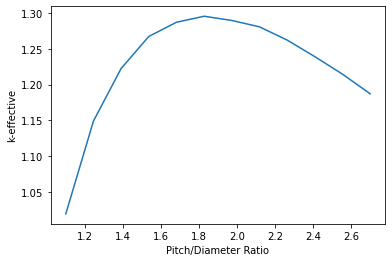

In [7]:
plt.plot(pitch_to_diameters,kVals_endf)
plt.xlabel('Pitch/Diameter Ratio')
plt.ylabel('k-effective')

# My ZrH Data

In [8]:
h_in_zrh  = openmc.data.ThermalScattering.from_njoy('h1.endf'  ,
            'my_ZrH/HinZrH/tape20' ,temperatures=[293.6], 
            stdout=False, njoy_exec='/Users/ameliajo/NJOY2016/bin/njoy')
zr_in_zrh = openmc.data.ThermalScattering.from_njoy('zr90.endf',
            'my_ZrH/ZrinZrH/tape20',temperatures=[293.6], 
            stdout=False, njoy_exec='/Users/ameliajo/NJOY2016/bin/njoy')

if os.path.exists("c_H_in_ZrH.h5"):
    os.remove( "c_H_in_ZrH.h5")
    os.remove("c_Zr_in_ZrH.h5")
h_in_zrh.export_to_hdf5('c_H_in_ZrH.h5')
zr_in_zrh.export_to_hdf5('c_Zr_in_ZrH.h5')

!{'cp c_H_in_ZrH.h5 /Users/ameliajo/endfb71_hdf5/'}
!{'cp c_Zr_in_ZrH.h5 /Users/ameliajo/endfb71_hdf5/'}



In [9]:
# Geometry 

pitch = 1.26
pitch_to_diameters = [1.4,1.5,1.6,1.8]
pitch_to_diameters = np.linspace(1.1,2.7,12)
kVals_myZrH = []
for ratio in pitch_to_diameters:
    left    = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
    right   = openmc.XPlane(x0= pitch/2, boundary_type='reflective')
    bottom  = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
    top     = openmc.YPlane(y0= pitch/2, boundary_type='reflective')
    fuel_diameter = pitch/ratio
    fuel_or = openmc.ZCylinder(r=fuel_diameter*0.5)

    fuel_region = -fuel_or
    mod_region  = +left & -right & +bottom & -top & +fuel_or

    fuel = openmc.Cell(1, 'fuel')
    fuel.fill = uo2
    fuel.region = fuel_region

    moderator = openmc.Cell(2, 'moderator')
    moderator.fill = zrh
    moderator.region = mod_region

    root = openmc.Universe(cells=(fuel, moderator))
    geom = openmc.Geometry(root)
    geom.export_to_xml()

    # Run
    openmc.run()

    # Retrieve k-efffective
    sp = openmc.StatePoint('statepoint.100.h5')
    k = sp.k_combined.n
    kVals_myZrH.append(k)
    !{'rm *.h5 geometry.xml'}


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k         

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k         

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k         

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k         

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 k-effective (Collision)     = 1.21540 +/- 0.00190
 k-effective (Track-length)  = 1.21678 +/- 0.00233
 k-effective (Absorption)    = 1.21288 +/- 0.00135
 Combined k-effective        = 1.21358 +/- 0.00131
 Leakage Fraction            = 0.00000 +/- 0.00000

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                ####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k         

Text(0, 0.5, 'k-effective')

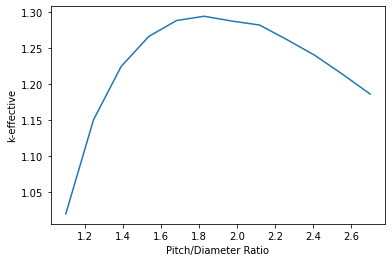

In [10]:
plt.plot(pitch_to_diameters,kVals_myZrH)
plt.xlabel('Pitch/Diameter Ratio')
plt.ylabel('k-effective')

Text(0, 0.5, 'k-effective')

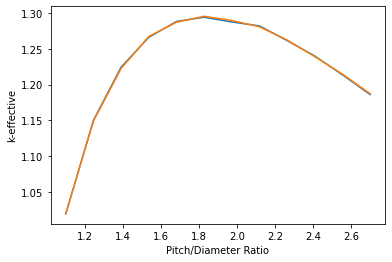

In [11]:
plt.plot(pitch_to_diameters,kVals_myZrH)
plt.plot(pitch_to_diameters,kVals_endf)
plt.xlabel('Pitch/Diameter Ratio')
plt.ylabel('k-effective')

# My ZrH$_2$ Data

In [12]:
h_in_zrh  = openmc.data.ThermalScattering.from_njoy('h1.endf'  ,
            'my_ZrH2/HinZrH2/tape20' ,temperatures=[293.6], 
            stdout=False, njoy_exec='/Users/ameliajo/NJOY2016/bin/njoy')
zr_in_zrh = openmc.data.ThermalScattering.from_njoy('zr90.endf',
            'my_ZrH2/ZrinZrH2/tape20',temperatures=[293.6], 
            stdout=False, njoy_exec='/Users/ameliajo/NJOY2016/bin/njoy')

if os.path.exists("c_H_in_ZrH.h5"):
    os.remove( "c_H_in_ZrH.h5")
    os.remove("c_Zr_in_ZrH.h5")
h_in_zrh.export_to_hdf5('c_H_in_ZrH.h5')
zr_in_zrh.export_to_hdf5('c_Zr_in_ZrH.h5')

!{'cp c_H_in_ZrH.h5 /Users/ameliajo/endfb71_hdf5/'}
!{'cp c_Zr_in_ZrH.h5 /Users/ameliajo/endfb71_hdf5/'}



In [13]:
# Geometry 

pitch = 1.26
pitch_to_diameters = [1.4,1.5,1.6,1.8]
pitch_to_diameters = np.linspace(1.1,2.7,12)
kVals_myZrH2 = []
for ratio in pitch_to_diameters:
    left    = openmc.XPlane(x0=-pitch/2, boundary_type='reflective')
    right   = openmc.XPlane(x0= pitch/2, boundary_type='reflective')
    bottom  = openmc.YPlane(y0=-pitch/2, boundary_type='reflective')
    top     = openmc.YPlane(y0= pitch/2, boundary_type='reflective')
    fuel_diameter = pitch/ratio
    fuel_or = openmc.ZCylinder(r=fuel_diameter*0.5)

    fuel_region = -fuel_or
    mod_region  = +left & -right & +bottom & -top & +fuel_or

    fuel = openmc.Cell(1, 'fuel')
    fuel.fill = uo2
    fuel.region = fuel_region

    moderator = openmc.Cell(2, 'moderator')
    moderator.fill = zrh
    moderator.region = mod_region

    root = openmc.Universe(cells=(fuel, moderator))
    geom = openmc.Geometry(root)
    geom.export_to_xml()

    # Run
    openmc.run()

    # Retrieve k-efffective
    sp = openmc.StatePoint('statepoint.100.h5')
    k = sp.k_combined.n
    kVals_myZrH2.append(k)
    !{'rm *.h5 geometry.xml'}


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


 Reading U238 from /Users/ameliajo/endfb71_hdf5/U238.h5
 Reading O16 from /Users/ameliajo/endfb71_hdf5/O16.h5
 Reading Zr90 from /Users/ameliajo/endfb71_hdf5/Zr90.h5
 Reading Zr91 from /Users/ameliajo/endfb71_hdf5/Zr91.h5
 Reading Zr92 from /Users/ameliajo/endfb71_hdf5/Zr92.h5
 Reading Zr94 from /Users/ameliajo/endfb71_hdf5/Zr94.h5
 Reading Zr96 from /Users/ameliajo/endfb71_hdf5/Zr96.h5
 Reading H1 from /Users/ameliajo/endfb71_hdf5/H1.h5
 Reading H2 from /Users/ameliajo/endfb71_hdf5/H2.h5
 Reading c_H_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_H_in_ZrH.h5
 Reading c_Zr_in_ZrH from /Users/ameliajo/endfb71_hdf5/c_Zr_in_ZrH.h5
 Minimum neutron data temperature: 294.000000 K
 Maximum neutron data temperature: 294.000000 K
 Preparing distributed cell instances...
 Writing summary.h5 file...
 Maximum neutron transport energy: 20000000.000000 eV for U235
 Initializing source particles...

 ====================>     K EIGENVALUE SIMULATION     <====================

  Bat./Gen.      k         

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=1.
  warn(msg, IDWarning)
//anaconda3/envs/openmc-env/lib/python3.8/site-packages/openmc/mixin.py:68: IDWarning: Another Cell instance already exists with id=2.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

Text(0, 0.5, 'k-effective')

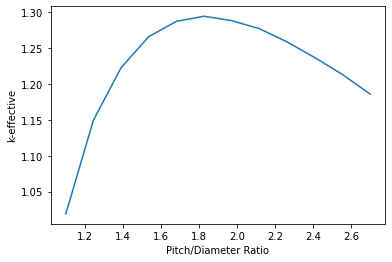

In [14]:
plt.plot(pitch_to_diameters,kVals_myZrH2)
plt.xlabel('Pitch/Diameter Ratio')
plt.ylabel('k-effective')

Text(0, 0.5, 'k-effective')

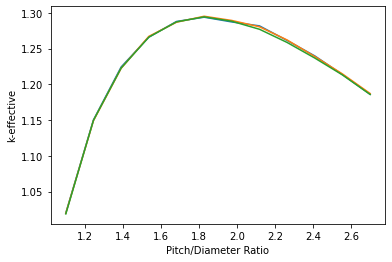

In [15]:
plt.plot(pitch_to_diameters,kVals_myZrH)
plt.plot(pitch_to_diameters,kVals_endf)
plt.plot(pitch_to_diameters,kVals_myZrH2)

plt.xlabel('Pitch/Diameter Ratio')
plt.ylabel('k-effective')